In [1]:
import iris
import glob
import iris.plot as iplt
import iris.quickplot as qplt
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import dask.array as da
import time

In [2]:
# # monthly_cubes = []

# for year in range(2010, 2020):
#     print(year)
#     radardir = f'/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/{year}/'
#     file_list = glob.glob(radardir + "*.nc")
#     sorted_list = sorted(file_list)
    
#     # Load and concatenate cubes for the current year
#     cubes = iris.load(sorted_list)
    
#     # Update metadata of all cubes
#     for cube in cubes:
#         cube.metadata = cubes[0].metadata  
#     print("doing dtypes")    
#     common_dtype = cubes[0].data.dtype
#     for cube in cubes:
#         cube.data = cube.data.astype(common_dtype) 
        
#     monthly_cube = cubes.concatenate_cube()
    
#     monthly_cubes.append(monthly_cube)

# # Concatenate cubes for all years
# combined_cube = iris.cube.CubeList(monthly_cubes).concatenate_cube()

# # Extract grid cell data and compute the maximum
# this_grid_cell = combined_cube[:, 825, 891]


In [3]:
# file_list = glob.glob(radardir + "*.nc")
# sorted_list = sorted(file_list)

# # Load and concatenate cubes
# cubes = iris.load(sorted_list)

# # Update metadata of all cubes
# for cube in cubes:
#     cube.metadata = cubes[0].metadata  

# monthly_cube = cubes.concatenate_cube()

# # Extract grid cell data and compute the maximum
# this_grid_cell = monthly_cube[:, 825, 891]

In [4]:
# def find_seasonal_max(radardir):
#     file_list = glob.glob(radardir + "*.nc")
#     sorted_list = sorted(file_list)

#     # Load and concatenate cubes
#     cubes = iris.load(sorted_list)

#     # Update metadata of all cubes
#     for cube in cubes:
#         cube.metadata = cubes[0].metadata  

#     monthly_cube = cubes.concatenate_cube()
#     this_grid_cell = monthly_cube[:, 825, 891]
#     return np.nanmax(this_grid_cell.data)

# # Define the directory and create a list of file paths
# filepaths = [f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/' for year in range(2006, 2020)]

# # Process files in parallel
# results = [find_monthly_max(file_path) for file_path in filepaths]
# results


In [2]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Create path to files containing functions
root_fp = "/nfs/a319/gy17m2a/PhD/"
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *
gb_gdf = create_gb_outline({'init' :'epsg:3857'})

In [3]:
def find_all_max_locations_in_timeslices(cube):
    """
    Finds the maximum value in each timeslice and returns all its locations.
    
    Args:
        cube (iris.cube.Cube): The Iris cube to analyze.

    Returns:
        list: Each element is a tuple containing the timeslice index, maximum value, 
              and a list of coordinates where the maximum occurs.
    """
    results = []
    time_dimension = 0  # Adjust if your time dimension is not the first dimension
    
    # Iterate over each timeslice
    for i, timeslice in enumerate(cube.slices_over(time_dimension)):
        max_value = np.max(timeslice.data)
        # Find all positions where the timeslice data equals the maximum value
        positions = np.argwhere(timeslice.data == max_value)
        
        # Get the corresponding latitude and longitude for each position
        max_locations = []
        for pos in positions:
            latitude = timeslice.coord('projection_y_coordinate').points[pos[0]]
            longitude = timeslice.coord('projection_x_coordinate').points[pos[1]]
            max_locations.append((latitude, longitude))
        
        # Store the results
        results.append((i, max_value, max_locations))
    
    return results


In [6]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import Point
# from pyproj import Proj, transform
# import pandas as pd

# windfarms = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/NIMROD/windfarms.csv', encoding='latin1')
# windfarms =windfarms[windfarms['Technology Type']=='Wind Onshore']
# windfarms = windfarms[(windfarms['Development Status'] == 'Operational') | (windfarms['Development Status'] == 'Decommissioned')]

# # Read shapefile of UK outline
# uk_outline = gpd.read_file('/nfs/a319/gy17m2a/PhD/datadir/SpatialData/UK_shp/GBR_adm0.shp')

# # Define a function to convert BNG coordinates to latitude and longitude
# def bng_to_latlon(x, y):
#     in_proj = Proj(init='epsg:27700')  # British National Grid projection
#     out_proj = Proj(init='epsg:4326')  # WGS84 (latitude and longitude) projection
#     lon, lat = transform(in_proj, out_proj, x, y)
#     return lon, lat

# # # Read DataFrame with BNG coordinates
# df = windfarms

# # # Convert BNG coordinates to latitude and longitude
# df['lon'], df['lat'] = zip(*df.apply(lambda row: bng_to_latlon(row['X-coordinate'], row['Y-coordinate']), axis=1))

# # # Convert DataFrame to GeoDataFrame
# # geometry = [Point(lon, lat) for lon, lat in zip(df['lon'], df['lat'])]
# # gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# # # Plot the UK outline and points
# # fig, ax = plt.subplots(figsize=(10, 10))
# # uk_outline.plot(ax=ax, color='lightgrey', edgecolor='black')
# # gdf.plot(ax=ax, color='red', markersize=5)
# # plt.xlabel('Longitude')
# # plt.show()

### Read in all data for one month and join into one cube

In [3]:
# Define the directory and create a sorted list of file paths
year = 2016
radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
file_list = glob.glob(radardir + "*.nc")
sorted_list = sorted(file_list)

# Load the cubes
cubes = iris.load(sorted_list[:30])

common_metadata = cubes[0].metadata

# Update metadata of all cubes
for cube in cubes:
    cube.metadata = common_metadata  

# Concatenate into a single cube
monthly_cube = cubes.concatenate_cube()

### Sum the values across this month

In [154]:
# # Assuming the time dimension is the first dimension
summed_cube = monthly_cube.collapsed('time', iris.analysis.SUM)

In [155]:
summed_cube = trim_to_bbox_of_region_obs(summed_cube, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

In [156]:
summed_cube_copy = summed_cube.copy()
iris.save(summed_cube, 'summed_cube_2016.nc')

In [139]:
# Mask values where data is below 10
# summed_cube_copy.data = np.ma.masked_less(summed_cube_copy.data, 1)

### Find the count of values over a certain value

In [ ]:
start = time.time()

# Step 1: Extract data
projection_y_coord = monthly_cube.coord('projection_y_coordinate')
projection_x_coord = monthly_cube.coord('projection_x_coordinate')
data_values = monthly_cube.data

# Step 2: Thresholding (with Dask for parallel processing)
data_values_dask = da.from_array(data_values, chunks=(100, 500, 500))
threshold_count = da.sum_nonzero(data_values_dask > 20, axis=0)

# Step 3: Create new cube
new_cube = iris.cube.Cube(threshold_count.compute(),
                          dim_coords_and_dims=[(projection_y_coord, 0),
                                               (projection_x_coord, 1)])

# Now, new_cube contains the counts of times a value of 10 is exceeded in the original data for each combination of projection_y_coordinate and projection_x_coordinate.
end= time.time()
print(round(end-start,2))

### Trim so its smaller

In [104]:
# summed_cube = trim_to_bbox_of_region_obs(summed_cube, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')
new_cube= trim_to_bbox_of_region_obs(new_cube, gb_gdf, 'projection_y_coordinate', 'projection_x_coordinate')

### Plot

In [105]:
new_cube.data = np.ma.masked_less(new_cube.data, 1)

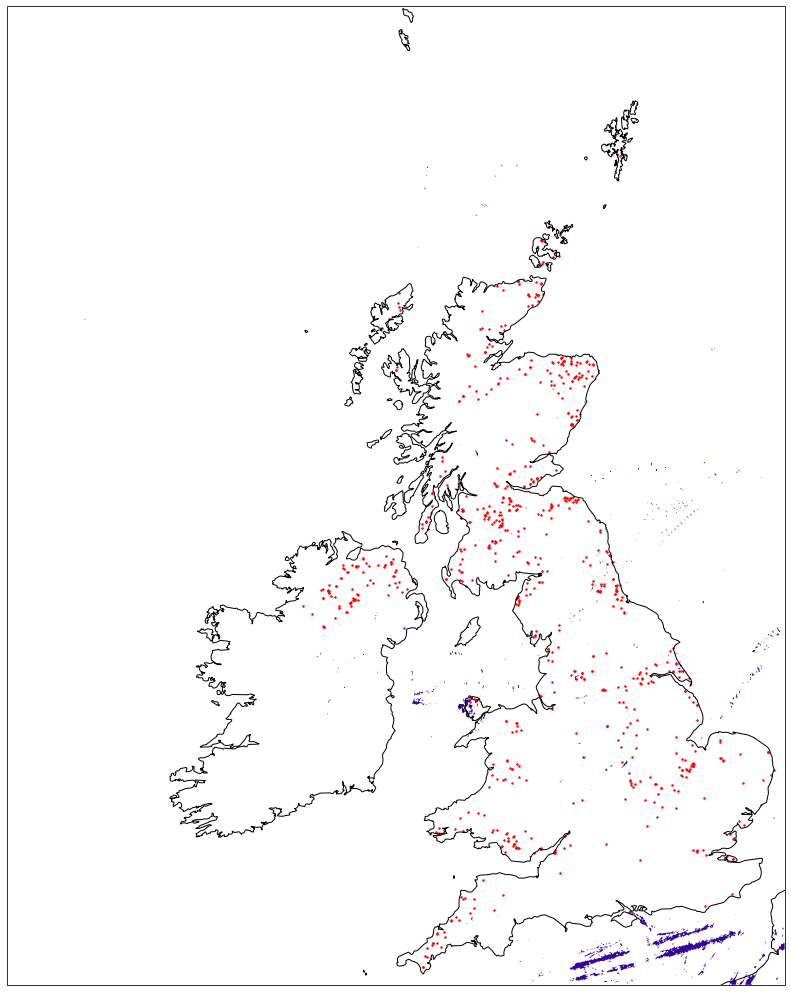

In [106]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import pyproj
import numpy as np

# Define projection for British National Grid
bng_proj = pyproj.Proj(init='epsg:27700')  # British National Grid projection

# Convert latitude and longitude coordinates to BNG
df['X-coordinate'], df['Y-coordinate'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), bng_proj, df['lon'].values, df['lat'].values)

# Create a plot
plt.figure(figsize=(30, 18))

# Plot contourf with Iris
iplt.contourf(new_cube, cmap='plasma')  # Adjust the colormap as needed

# Overlay points
plt.scatter(df['X-coordinate'], df['Y-coordinate'], color='red', s=2)  # Assuming df contains the converted BNG coordinates

# Add coastlines with Cartopy if needed
plt.gca().coastlines()

# Save or show the plot
plt.savefig('CountValuesOver160.jpg', dpi=1000, bbox_inches='tight')
plt.show()


### Check for repeated occurrence of value

In [5]:
for i in range(0,5):
    day_cube = iris.load_cube(sorted_list[i])
    numbers, counts = np.unique(day_cube.data.data, return_counts=True)
    df=pd.DataFrame({'numbers':numbers, 'counts':counts})
    df = df.sort_values(by='numbers', ascending=False)
    print(df[:3])

           numbers     counts
1467  9.969210e+36  768143373
1466  1.023969e+03        222
1465  1.015344e+03          1
           numbers     counts
4690  9.969210e+36  769132051
4689  1.023969e+03         36
4688  1.018750e+03          1
           numbers     counts
1719  9.969210e+36  770928656
1718  1.023969e+03          9
1717  9.740625e+02          1


KeyboardInterrupt: 

### Check spatial/temporal occurrence of value

In [84]:
day_cube = iris.load_cube(sorted_list[2])

In [6]:
global_max_value = np.nanmax(day_cube.data)

In [12]:
# Example usage
max_values_and_all_locations = find_all_max_locations_in_timeslices(day_cube)
for result in max_values_and_all_locations:
    print(f"Timeslice Index: {result[0]}, Max Value: {result[1]}, Locations: {result[2]}")

Timeslice Index: 0, Max Value: 91.84375, Locations: [(-132500.0, 601500.0)]
Timeslice Index: 1, Max Value: 75.625, Locations: [(-155500.0, 610500.0)]
Timeslice Index: 2, Max Value: 58.40625, Locations: [(524500.0, 69500.0)]
Timeslice Index: 3, Max Value: 52.40625, Locations: [(-154500.0, 616500.0)]
Timeslice Index: 4, Max Value: 52.4375, Locations: [(-146500.0, 623500.0)]
Timeslice Index: 5, Max Value: 54.59375, Locations: [(-148500.0, 624500.0), (-148500.0, 625500.0), (-147500.0, 625500.0), (-146500.0, 625500.0), (-145500.0, 625500.0), (-145500.0, 626500.0)]
Timeslice Index: 6, Max Value: 89.21875, Locations: [(-137500.0, 559500.0)]
Timeslice Index: 7, Max Value: 68.6875, Locations: [(-134500.0, 561500.0)]
Timeslice Index: 8, Max Value: 139.59375, Locations: [(524500.0, 69500.0)]
Timeslice Index: 9, Max Value: 42.1875, Locations: [(-194500.0, 594500.0)]
Timeslice Index: 10, Max Value: 48.65625, Locations: [(524500.0, 69500.0)]
Timeslice Index: 11, Max Value: 44.25, Locations: [(524500

In [ ]:
# # day_cube#95500.0, 457500.0
# # day_cube[day_cube['projection_coordinate'] == 95500]

# y_constraint = iris.Constraint(projection_y_coordinate=lambda y: y == 95500.0)
# x_constraint = iris.Constraint(projection_x_coordinate=lambda x: x == 457500.0)

# constrained_cube = day_cube.extract(y_constraint & x_constraint)

# # Flatten the data to a one-dimensional array
# data_flat = constrained_cube.data.flatten()

# # Sort the data in descending order
# data_sorted_desc = np.sort(data_flat)[::-1]

# # Print the sorted data
# print(data_sorted_desc)


In [8]:
# for entry in max_values_and_all_locations:
#     if entry[1] == global_max_value:
#         print(f"Timeslice Index: {entry[0]}, Max Value: {entry[1]}, Location: (Lat: {entry[2]}, Lon: {entry[3]})")

# Part 2: find cells where there are lots of high values

In [5]:
import iris
import glob
import numpy as np
from scipy import stats

# Define the directory and create a sorted list of file paths
year = 2012
radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
file_list = glob.glob(radardir + "*.nc")
sorted_list = sorted(file_list)

# Load the cubes
cubes = iris.load(sorted_list[:30])

# Concatenate into a single cube
monthly_cube = cubes.concatenate_cube()

# Assuming the time dimension is the first dimension
summed_cube = monthly_cube.collapsed('time', iris.analysis.SUM)

In [ ]:
# cubes = iris.load(sorted_list)
# yearly_cube = cubes.concatenate_cube()

### Sum over time

### Load data and concatenate

In [22]:
# np.nanmin(monthly_cube.data)
test = monthly_cube[2,:,:]
np.nanmin(test.data)

0.0

In [7]:
# Assuming the time dimension is the first dimension
accumulated_cube = monthly_cube.collapsed('time', iris.analysis.SUM)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_reference_time'.
  warnings.warn(msg.format(self.name()))


In [56]:
# accum_data_flat = accumulated_cube.data.flatten()

In [60]:
data_sorted_desc = np.sort(accum_data_flat.data)[::-1]
data_sorted_desc[:30]

array([179373.12 , 143786.06 ,  97689.25 ,  87672.53 ,  76027.03 ,
        76000.09 ,  72193.91 ,  65293.25 ,  65148.156,  61023.656,
        55669.97 ,  53700.78 ,  52444.   ,  52325.625,  52325.03 ,
        45329.156,  44527.78 ,  44190.438,  44075.812,  36364.938,
        31203.188,  31119.844,  30162.156,  29983.25 ,  29225.   ,
        28448.438,  26905.   ,  26678.281,  26105.031,  26038.062],
      dtype=float32)

### Find values over whole month at cells we know to have high values for one timeslice

In [65]:
# day_cube#95500.0, 457500.0
# day_cube[day_cube['projection_coordinate'] == 95500]

y_constraint = iris.Constraint(projection_y_coordinate=lambda y: y == 86500.0)
x_constraint = iris.Constraint(projection_x_coordinate=lambda x: x == 471500.0)
constrained_cube2 = yearly_cube.extract(y_constraint & x_constraint)

# Flatten the data to a one-dimensional array
data2_flat = constrained_cube2.data.flatten()

# Sort the data in descending order
data_sorted_desc = np.sort(data_flat)[::-1]

# Print the sorted data
print(data_sorted_desc)

[1023.96875 1023.96875 1023.96875 ...    0.         0.         0.     ]


In [68]:
test = pd.DataFrame({'data':data2_flat, 'index':range(0,len(data2_flat))})
test.sort_values(by='data', ascending=False)[:30]

,data,index
10067,1023.96875,10067
11765,555.68750,11765
13806,512.53125,13806
857,466.40625,857
23310,360.90625,23310
1706,353.43750,1706
10013,343.56250,10013
18477,307.75000,18477
387,293.84375,387
10638,219.31250,10638


In [66]:
test = pd.DataFrame({'data':data2_flat, 'index':range(0,len(data_flat))})
test.sort_values(by='data', ascending=False)[:40]

ValueError: All arrays must be of the same length

### Identify outlying values

In [ ]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy.ma as ma

# Load data
cube = accumulated_cube

# Mask out zeros
cube.data = ma.masked_equal(cube.data, 0)
cube.data = np.ma.masked_where(cube.data < 25000, cube.data)

# Plotting
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 2, 49, 61], crs=ccrs.PlateCarree())  # Zoom in on the UK
ax.coastlines()

# Use Iris' quickplot for easy plotting
qplt.contourf(cube, cmap='viridis_r')  # Indexing [0] for the first time point, adjust as necessary
plt.title('Precipitation Over the UK (Non-zero values)')
plt.colorbar(orientation='vertical')
plt.show()

### Handle outliers

In [ ]:
# Get indices where there are outliers
outlier_indices = np.where(outliers)

# Optional: Print the locations and values of outliers
for index in zip(*outlier_indices):
    print(f"Outlier at index {index} with value {accumulated_cube.data[index]} and z-score {z_scores[index]}")
